# Exam 04/07/2025

# Excercise 1

Si considerino i due sistemi lineari:

    A  x = b 
    A1 x1 = b1

dove A, A1 sono le matrici dei coefficienti, b e b1 sono i termini noti, ed x ed x1 sono i vettori incogniti da determinare. I dati di questi due sistemi lineari sono contenuti nel file **matrix-V.mat**.
 - Si risolva ciascuno dei sistemi lineari assegnati  utilizzando il metodo più adatto in base alle caratteristiche della matrice dei coefficienti, giustificando teoricamente le scelte effettuate. **punti 6**

Per il sistema A1 x1= b1, , aggiungere una perturbazione dello 0.1% sulla componente 1-esima del termine noto, e risolvere il sistema con termine noto perturbato. Calcolare quindi l'errore relativo sulla soluzione e l'errore relativo sui dati e giustificare i risultati alla luce della teoria. **punti 2**

In [237]:
from SolveTriangular import *
import scipy

def metodo_gaus(A, b):
    PT, L, U = scipy.linalg.lu(A)
    P = PT.T
    y, flag = Lsolve(L, P @ b)
    if not flag:
        x = Usolve(U, y)
    
    return x

def SVDLS(A, b):
    m, n = A.shape
    U, s, VT = scipy.linalg.svd(A)

    V = VT.T

    thresh = np.spacing(1) * m * s[0]
    k = np.count_nonzero(s > thresh)
    print("rango =", k)

    d = U.T @ b
    d1 = d[:k].reshape(k, 1)
    s1 = s[:k].reshape(k, 1)

    c = d1 / s1
    x = V[:, :k] @ c

    return x, np.linalg.norm(d[k:]) ** 2

In [238]:
from scipy.io import loadmat
import matplotlib.pylab as plt
import numpy as np

dati = loadmat("./mat/matrix-V.mat")
A = dati["A"].astype(float)
b = dati["b"].astype(float)

A1 = dati["A1"].astype(float)
b1 = dati["b1"].astype(float)


def isQuadratic(A):
    return A.shape[0] == A.shape[1]


def isSymmetric(A):
    return np.allclose(A, A.T)


def isPositive(A):
    return np.all(np.linalg.eigvals(A) > 0)


def isSparse(A):
    return np.count_nonzero(A) < A.size * 0.33


def rank(A, b):
    return np.linalg.matrix_rank(A) == np.linalg.matrix_rank(np.hstack([A, b]))


print("[A] quadratica?", isQuadratic(A))
print("[A] simmetrica?", isSymmetric(A))
print("[A] def. positiva?", isPositive(A))
print("[A] sparsa?", isSparse(A))
print("[A] dimensione:", A.shape)
print("[A] rango massimo?", rank(A, b))
print("[A] condizionamento:", np.linalg.cond(A), "\n")

# la prima matrice [A], è ben condizionata non grande ed è quadratica, simmetrica e positiva
# possiamo usare i metodi di fattorizzazione, quello più opportuno è la fattorizzazione di Gauss
x, _ = metodo_gaus(A, b)

print("[A] soluzione:", x.flatten(), "\n")

print("[A1] quadratica?", isQuadratic(A1))
print("[A1] sparsa?", isSparse(A1))
print("[A1] dimensione:", A1.shape)
print("[A1] rango:", np.linalg.matrix_rank(A1))
print("[A1] condizionamento:", np.linalg.cond(A1), "\n")

# invece per la seconda matrice [A1], abbiamo una matrice non quadrata, quindi dobbiamo usare
# i metodi risolutivi per i metodo sovradimensionati, essendo poi mal condizionata e non avendo
# rango massimo andrò ad utilizzare il metodo SVDLS.
x_sv, re_sv = SVDLS(A1, b1)

# Perturbazione 0.1% sulla prima componente di b1
b1_perturb = b1.copy()
b1_perturb[0] = b1_perturb[0] * 1.001  # +0.1%

x_p_sv, re_p_sv = SVDLS(A1, b1_perturb)

# Calcolo errori relativi
err_sol_rel = np.linalg.norm(x_p_sv.flatten() - x_sv.flatten()) / np.linalg.norm(x_sv.flatten())
err_data_rel = np.linalg.norm(b1_perturb - b1) / np.linalg.norm(b1)

print("Errore relativo sulla soluzione (perturbata):", err_sol_rel)
print("Errore relativo sui dati:", err_data_rel)

# poiche A1 è mal condizionata, anche piccole peturbazoni nel vettore dei termini noti, possono provocare variazioni
# amplificate sulla soluzione. Il problema, numerico risulta sensibile e instabile, la soluzione non è robusta
# rispetto a piccoli errori o rumore nei dati

[A] quadratica? True
[A] simmetrica? True
[A] def. positiva? True
[A] sparsa? False
[A] dimensione: (10, 10)
[A] rango massimo? True
[A] condizionamento: 12.81454459956794 

[A] soluzione: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

[A1] quadratica? False
[A1] sparsa? False
[A1] dimensione: (20, 15)
[A1] rango: 13
[A1] condizionamento: 1.5940716803849085e+17 

rango = 13
rango = 13
Errore relativo sulla soluzione (perturbata): 0.002306878675159038
Errore relativo sui dati: 0.00025999894214178917


Dato il sistema lineare A2 x2 = b2, dove 

    A2 = np.array([[8.0, 0, 1, 1], [0, 0.8, 1, 0], [1, 1, 2, 0], [1, 0, 0.0, 2.0]])
    b2 = np.array([10.0, 1.8, 4.0, 3.0])

- Verificare senza calcolare il raggio spettrale della matrice di iterazione che il metodo di Gauss-Seidel converge, richiamando il teorema che garantisce la convergenza di Gauss-Seidel per classi particolari di 
matrici **punti[1]**.
- Implementare il metodo di Gauss-Seidel e risolvere il sistema lineare A2 x2 = b2  **punti[3]**.

Totale **Punti 12**

In [239]:
import numpy as np


def Lsolve(L, b):
    m, n = L.shape
    if n != m:
        print("errore: matrice non quadrata")
        return [], 1

    if np.any(np.diag(L) == 0):
        print("el. diag. nullo - matrice triangolare inferiore")
        return [], 1

    # Ensure b is a column vector
    if b.ndim == 1:
        b = b.reshape(-1, 1)
    elif b.ndim == 2 and b.shape[1] != 1:
        b = b.reshape(-1, 1)

    x = np.zeros((n, 1))
    for i in range(n):
        s = np.dot(L[i, :i], x[:i])
        x[i] = (b[i, 0] - s) / L[i, i]

    return x, 0


def gauss_seidel(A, b, x0, max_it=100, toll=1e-12):
    if b.ndim == 1:
        b = b.reshape(-1, 1)

    errore = 1000
    d = np.diag(A)
    D = np.diag(d)
    E = np.tril(A, -1)
    F = np.triu(A, 1)
    M = D + E
    N = -F
    invM = np.linalg.inv(M)
    T = invM @ N
    autovalori = np.linalg.eigvals(T)
    raggiospettrale = np.max(np.abs(autovalori))
    print("raggio spettrale Gauss-Seidel ", raggiospettrale)

    er = []
    while len(er) <= max_it and errore >= toll:
        x, flag = Lsolve(M, b - F @ x0)
        if flag == 1:  # Error in Lsolve
            break
        errore = np.linalg.norm(x - x0) / np.linalg.norm(x)
        er.append(errore)
        x0 = x.copy()

    return x, er, len(er)

In [ ]:
import numpy as np

A2 = np.array([[8.0, 0, 1, 1], [0, 0.8, 1, 0], [1, 1, 2, 0], [1, 0, 0.0, 2.0]])
b2 = np.array([10.0, 1.8, 4.0, 3.0])

# andrò a fare le stesse verifiche fatte sopra
print("[A2] è quadratica?", isQuadratic(A2))
print("[A2] è simmetrica?", isSymmetric(A2))
print("[A2] è postivia?", isPositive(A2))
print("[A2] è dimensione? dimensione =", A2.shape)
print("[A2] è sparsa?", isSparse(A2))
print("[A2] è conizionamento?", np.linalg.cond(A2))
print("[A2] ha rango massimo?", rank(A, b))

print("")

# su questo sistema possimo applicare il metodo di gauss-seidel e converge, perche da teorema
# la matrice A è definita positiva e simmetrica
x0 = np.zeros((b2.size, 1))
x_gs, xk_gs, it_gs = gauss_seidel(A2, b2, x0)

print("[A2] iterazioni Gauss- Seidel", it_gs, "\n")

# soluzione giusta
x_exact = np.linalg.solve(A2, b2)

print("Errore relativo", np.linalg.norm(x_gs.flatten() - x_exact) / np.linalg.norm(x_exact))
print("Soluzione esatta:", x_exact)
print("Soluzione Gauss-Seidel:", x_gs.flatten())

[A2] è quadratica? True
[A2] è simmetrica? True
[A2] è postivia? True
[A2] è dimensione? dimensione = (4, 4)
[A2] è sparsa? False
[A2] è conizionamento? 41.85857755643042
[A2] ha rango massimo? True

raggio spettrale Gauss-Seidel  0.6936887195995491
[A2] iterazioni Gauss- Seidel 74

Errore relativo 1.98854739194129e-12
Soluzione esatta: [1. 1. 1. 1.]
Soluzione Gauss-Seidel: [1. 1. 1. 1.]


# Excercise 2

Per ogni $k \in N$ l'equazione di II grado $x^2+(4^{2k}-2^{-2k})x-4^{2k}2^{-2k}=0 $ ha come soluzioni esatte $x_1=-4^{2k}$,$x_2=2^{-2k}$,

Scrivere lo script python in cui
- si implementa la formula risolutiva delle equazioni di II grado per calcolare le  due soluzioni per $k$ che  assume valori interi tra 4 e 12;  [**Punti 2**]
- per entrambe le soluzioni, si calcola l'errore relativo commesso al variare di k che assume valori interi tra 4 e 12;   [**Punti 1**]
- si rappresentano in un grafico gli andamenti dei due errori relativi calcolati nel punto precedente; [**Punti 1**]
- osservando i grafici ottenuti, si dica se le formule utilizzate per calcolare le due soluzioni hanno dato luogo ad algoritmi stabili, motivando opportunamente la risposta alla luce della teoria.   [**Punti 4**]
- proporre ed implementare un algoritmo alternativo stabile per il calcolo della soluzione per cui la formula risolutiva classica si è dimostrata non essere stabile. [**Punti 2**]
- Ricavavare la formula che quantifica l'indice di condizionamento del problema di valutare una funzione $f:R \rightarrow R$ in un punto $x \in R$ [**punti 3**]

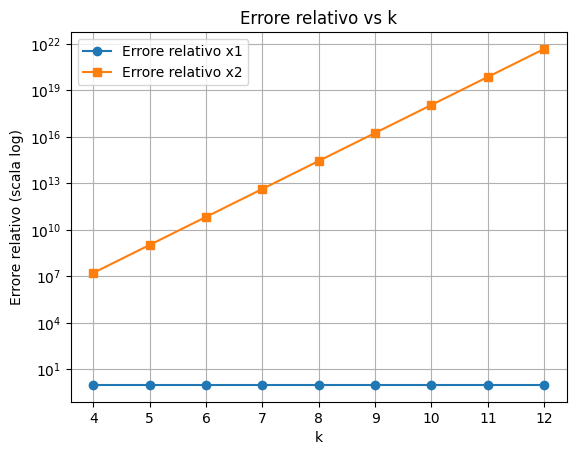

Errori relativi (classici): [np.float64(16777217.0), np.float64(1073741825.0), np.float64(68719476737.0), np.float64(4398046511105.0), np.float64(281474976710657.0), np.float64(1.8014398509481984e+16), np.float64(1.152921504606847e+18), np.float64(7.378697629483821e+19), np.float64(4.722366482869645e+21)]
Errori relativi (stabili): [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


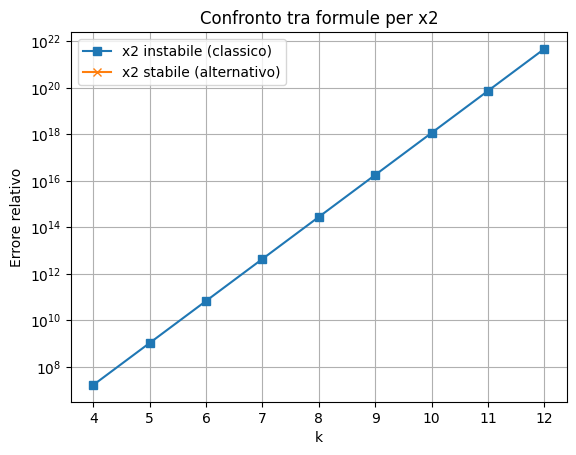

In [241]:
import numpy as np
import matplotlib.pyplot as plt

k_values = np.arange(4, 13)
err_rel_x1 = []
err_rel_x2 = []

for k in k_values:
    a = 1
    b = 4.0 ** (2 * k) - 2.0 ** (-2 * k)
    c = -(4.0 ** (2 * k)) * 2.0 ** (-2 * k)

    delta = b**2 - 4 * a * c
    sqrt_delta = np.sqrt(delta)

    x1 = (-b + sqrt_delta) / (2 * a)
    x2 = (-b - sqrt_delta) / (2 * a)

    x1_exact = -(4 ** (2 * k))
    x2_exact = 2.0 ** (-2 * k)

    # Errori relativi
    err_rel_x1.append(abs(x1 - x1_exact) / abs(x1_exact))
    err_rel_x2.append(abs(x2 - x2_exact) / abs(x2_exact))

plt.semilogy(k_values, err_rel_x1, "o-", label="Errore relativo x1")
plt.semilogy(k_values, err_rel_x2, "s-", label="Errore relativo x2")
plt.xlabel("k")
plt.ylabel("Errore relativo (scala log)")
plt.title("Errore relativo vs k")
plt.grid(True)
plt.legend()
plt.show()

# si nota che x1 è stabile invece x2 è instabile per k grandi, l'errore cresce rapidamente
err_rel_x2_alt = []
for k in k_values:
    a = 1
    b = 4.0 ** (2 * k) - 2.0 ** (-2 * k)
    c = -(4.0 ** (2 * k)) * 2.0 ** (-2 * k)

    delta = b**2 - 4 * a * c
    sqrt_delta = np.sqrt(delta)

    # Formula stabile: calcolo prima la radice "grande", poi uso c/(a*x) per la piccola
    x1_stabile = (-b - sqrt_delta) / (2 * a)  # Radice grande (x1 ≈ -4^{2k})
    x2_stabile = c / (a * x1_stabile)  # Radice piccola (x2 ≈ 2^{-2k})

    x2_exact = 2.0 ** (-2 * k)
    err_rel_x2_alt.append(abs(x2_stabile - x2_exact) / abs(x2_exact))

print("Errori relativi (classici):", err_rel_x2)
print("Errori relativi (stabili):", err_rel_x2_alt)

plt.semilogy(k_values, err_rel_x2, 's-', label='x2 instabile (classico)')
plt.semilogy(k_values, err_rel_x2_alt, 'x-', label='x2 stabile (alternativo)')
plt.xlabel("k")
plt.ylabel("Errore relativo")
plt.title("Confronto tra formule per x2")
plt.grid(True)
plt.legend()
plt.show()

# se f(x) è una funzione differenziabile in x, l'indice di condizionamento K(x) per il problema di valutare f(x)
# è dato da:

# k(x) = | (x * f'(x)) / f(x) |

# misura quando una piccola variazione realtiva di x si riflette in una variazione relativa di f(x).
# k(x) > 1 mal condizionato
# k(x) < 1 ben condizionato


# Domande Intelligenza Artificiale
**NB: Ogni risposta esatta:  +0.5 punti, ogni risposta errata: -0.5 punti. La mancanza di risposta:  0 punti**

Domande a risposta multipla

**1.** Quale delle seguenti affermazioni è FALSA riguardo alle reti MLP (Multilayer Perceptron)?
 - Le reti MLP sono composte da uno o più strati nascosti di neuroni.
 - Le reti MLP utilizzano una funzione di attivazione non lineare per introdurre una non linearità nel modello.
 - Le reti MLP sono in grado di apprendere solo relazioni lineari tra i dati di input e output.
 - Le reti MLP possono essere utilizzate per risolvere una vasta gamma di problemi di apprendimento automatico, tra cui la classificazione e la regressione.

In [242]:
# Risposta: PUNTO [**3**]

**2.** Quale delle seguenti affermazioni è la definizione CORRETTA di learning rate nel training di una rete neurale?
 - Il numero di volte in cui l'intero set di dati viene utilizzato durante il training.
 - Un parametro che controlla la velocità con cui i pesi della rete vengono aggiornati durante il training.
 - Il numero di neuroni presenti nello strato di output della rete.
 - La funzione di attivazione utilizzata dai neuroni della rete.ressione

In [243]:
# Risposta: PUNTO [**2**]

**3.** Quale tra le seguenti affermazioni descrive meglio il compito della funzione di attivazione nel training di una rete neurale?
 - Trasformare i dati di input in un formato compatibile con la rete neurale
 - Introdurre una non linearità nel flusso di informazioni della rete
 - Calcolare l'errore tra l'output previsto e quello effettivo
 - Aggiornare i pesi delle connessioni tra i neuroni softmax

In [244]:
# Risposta: PUNTO [**2**]

**4.** Quale delle seguenti definizioni descrive meglio un'epoca nel training di una rete neurale?
- Il numero di volte in cui viene aggiornato un singolo peso nella rete
- Il tempo impiegato per completare un ciclo di forward pass e backward propagation
- Il numero di volte in cui l'intero set di dati di training viene esposto alla rete
- Una misura della complessità del modello di rete neurale

In [245]:
# Risposta: PUNTO [**4**]

**5.** Quale tra le seguenti affermazioni è FALSA riguardo alla suddivisione del dataset in un contesto di machine learning?
- La suddivisione del dataset in set di training, validation e test è fondamentale per valutare correttamente le prestazioni di un modello di machine learning.
- Il set di training viene utilizzato per addestrare il modello sui dati.
- Il set di validation viene utilizzato per trovare le etichette dei dati di input
- Il set di test viene utilizzato per valutare le prestazioni finali del modello su dati che non sono stati utilizzati per il training o la validation.

In [246]:
# Risposta: PUNTO [**3**]

## Domande aperte

**6. Descrivi in cosa consiste la fase di forward-propagation e back-propagation nell'ambito del training di una rete neurale, soffermandoti sull'importanza dell'algoritmo di backpropagation** per il calcolo delle derivate parziali della funzione costo rispetto ai pesi di tutti i layer **[punti 1.5]**

In [247]:
# Forward-propagation
# È la fase in cui i dati di input passano attraverso la rete neurale, strato per strato, per calcolare l'output finale.
# Ogni neurone riceve un input, lo moltiplica per i pesi, aggiunge un bias e applica una funzione di attivazione (es. ReLU, sigmoid).

# Backward-propagation
# È la fase in cui si correggono i pesi della rete usando l’errore tra output previsto y^ e reale y
# Si calcolano le derivate della funzione costo rispetto ai pesi usando la regola della catena (derivata composta),
# propagando l’errore dall’output verso l’input.

# L’algoritmo di backpropagation è importante perché permette di calcolare queste derivate in modo efficiente per tutte le
# connessioni della rete, anche se è molto profonda, rendendo possibile l’apprendimento tramite
# metodi di ottimizzazione come la discesa del gradiente.

**7** Ricavare la formula di aggiornamento dei pesi mediante algoritmo di backpropagation nel caso di una rete MLP formata da un nodo di input, 2 layer nascosti ciascuno dei quali costituito da un solo neurone ed un nodo di output. **[punti: 3]**

In [248]:
# Abbiamo 1 nodo di input x, 2 layer nascosti e 1 nodo di output y
# input -> layer 1 -> layer 2 -> output

# Forward pass -> uscita = f(peso * input + bias) [f funzione tipo signoide o ReLU]
# Backward pass -> parte dall'output e torna indietro corrente i pesi, per farlo usa W(nuovo) = W(vecchio) - n * gradiente
# n in questo caso è la velocità di apprendimento